## AutoEncoder Experiments with notMNIST
Followings are the contents of this project:

A. Data Loading and Plotting

B. AutoEncoder Graph Construction
    1. Define the input output tensors
    2. Define the graph and construct it
    3. Define loss and optimizer

C. Run Session

D. Show some reconstructed images

E. Plot Embeddings

F. Do Image Generation by Decoder

In [1]:
import gzip
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
# from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data
# Shuffle arrays or sparse matrices in a consistent way
from sklearn.utils import shuffle
from six.moves import cPickle as pickle

outModelDir = './notMNIST-autoEncoder-shared-models-with-l2norm-on-embedding/'

## A. Data Loading and Plotting

In [2]:
# notMNIST data input domain is [-0.5 ~ 0.5]

dataPath='../dataset/'
pickle_file = dataPath + 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
# read the images
img_num = train_dataset.shape[0]
images = train_dataset.reshape([img_num,-1])
_, img_dim = images.shape
#images = tf.convert_to_tensor(images)
print('Images with shape {}'.format(images.shape))

Images with shape (200000, 784)


In [4]:
# read the labels
labels = train_labels
labels = labels[...,np.newaxis]
#lables = tf.convert_to_tensor(labels)
print('labels.shape = {}'.format(labels.shape))
n_classes = len(np.unique(labels))

labels.shape = (200000, 1)


In [5]:
def num2alphabet(i):
    assert 0<=i<=9
    return str.capitalize(chr(ord('a')+i))

print([num2alphabet(i) for i in range(10)])


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


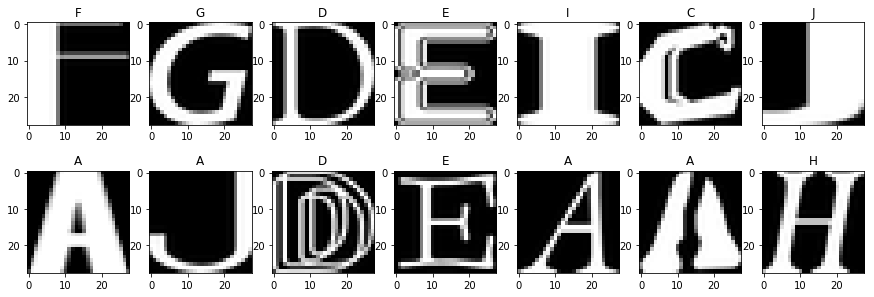

In [6]:
plt.figure(figsize=(15,5))
for i in np.arange(2*7):
    random_idx = np.random.randint(0,img_num)
    plt.subplot(2,7,i+1)
    plt.imshow(images[random_idx].reshape(28,28),cmap='gray')
    plt.title(num2alphabet(labels[random_idx][0]))

## B. AutoEncoder Graph Construction

1. Define the input output tensors
2. Define the graph and construct it
3. Define the loss and optimizer

#### First define the hyper-parameters

In [7]:
# Hyper-parameters
EPOCHS = 100
BATCH_SIZE = 128
rate = 0.001
l2_weight = 0.1

### 1. Define the input output tensors

In [8]:
x = tf.placeholder(tf.float32, (None, img_dim))
y = tf.placeholder(tf.float32, (None, img_dim))
embedding_dim = 2
code = tf.placeholder(tf.float32, (None, embedding_dim))

### 2. Define the graph and construct it

#### First, we define all the variables

In [9]:
mu = 0
sigma = 0.1
layer_dim = {
    'layer1': 128,
    'layer2': 32,
    'embedded': embedding_dim,
    'reconstruct': img_dim
}
with tf.variable_scope('AutoEncoder') as AEScope:
    layer1_w = tf.get_variable('layer1_w',shape=(img_dim,layer_dim['layer1']),\
                                initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma))
    layer1_b = tf.get_variable('layer1_b',shape=(layer_dim['layer1']),\
                                initializer=tf.zeros_initializer())
    layer2_w = tf.get_variable('layer2_w',shape=(layer_dim['layer1'],layer_dim['layer2']),\
                                initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma))
    layer2_b = tf.get_variable('layer2_b',shape=(layer_dim['layer2']),\
                                initializer=tf.zeros_initializer())
    embedded_w = tf.get_variable('embedded_w',shape=(layer_dim['layer2'],layer_dim['embedded']),\
                                initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma))
    embedded_b = tf.get_variable('embedded_b',shape=(layer_dim['embedded']),\
                                initializer=tf.zeros_initializer())
    reconstruct_b = tf.get_variable('reconstruct_b',shape=(layer_dim['reconstruct']),\
                                initializer=tf.zeros_initializer())
    
weights = {
    'layer1': layer1_w,
    'layer2': layer2_w,
    'embedded': embedded_w
}

biases = {
    'layer1': layer1_b,
    'layer2': layer2_b,
    'embedded': embedded_b,
    'reconstruct': reconstruct_b
}
    

In [10]:
all_collection = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=AEScope.name)
print('All collection ({}) having {} variables'.format(AEScope.name,len(all_collection)))

All collection (AutoEncoder) having 7 variables


#### Then we define the graph

In [11]:
def Encoder(x):
    # Layer 1 encode: Input = batch_num x img_dim. Output = batch_num x layer_dim['layer1'].
    layer1_en   = tf.matmul(x,weights['layer1']) + biases['layer1']
    print('layer1_en has shape=',layer1_en.shape)
    # Activation.
    layer1_en = tf.nn.relu(layer1_en)

    # Layer 2 encode: Input = batch_num x layer_dim['layer1']. Output = batch_num x layer_dim['layer2'].
    layer2_en   = tf.matmul(layer1_en,weights['layer2']) + biases['layer2']
    print('layer2_en has shape=',layer2_en.shape)
    # Activation.
    layer2_en = tf.nn.relu(layer2_en)

    # Layer embedded: Input = batch_num x layer_dim['layer2']. Output = batch_num x layer_dim['embedded'].
    embedded   = tf.matmul(layer2_en,weights['embedded']) + biases['embedded']
    print('embedded has shape=',embedded.shape)
    
    return embedded


def Decoder(embedded):
    # Layer 1 decode: Input = batch_num x layer_dim['embedded']. Output = batch_num x layer_dim['layer2'].
    embedded_t = tf.matmul(embedded,weights['embedded'],transpose_b=True) + biases['layer2']
    print('embedded_t has shape=',embedded_t.shape)
    # Activation.
    embedded_t = tf.nn.relu(embedded_t)

    # Layer 2 decode: Input = batch_num x layer_dim['layer2']. Output = batch_num x layer_dim['layer1'].
    layer2_t = tf.matmul(embedded_t,weights['layer2'],transpose_b=True) + biases['layer1']
    print('layer2_t has shape=',layer2_t.shape)
    # Activation.
    layer2_t = tf.nn.relu(layer2_t)
    
    # Layer reconstruct: Input = batch_num x layer_dim['layer1']. Output = batch_num x img_dim.
    reconstruct   = tf.matmul(layer2_t,weights['layer1'],transpose_b=True) + biases['reconstruct']
    print('reconstruct has shape=',reconstruct.shape)
    # Activation.
    
    return reconstruct


In [12]:
embedded = Encoder(x)
reconstruct = Decoder(code)

layer1_en has shape= (?, 128)
layer2_en has shape= (?, 32)
embedded has shape= (?, 2)
embedded_t has shape= (?, 32)
layer2_t has shape= (?, 128)
reconstruct has shape= (?, 784)


In [13]:
def AutoEncoder(x):    
    embedded = Encoder(x)
    reconstruct = Decoder(embedded)
    
    return [embedded, reconstruct]

[embedded_auto, reconstruct_auto] = AutoEncoder(x)

layer1_en has shape= (?, 128)
layer2_en has shape= (?, 32)
embedded has shape= (?, 2)
embedded_t has shape= (?, 32)
layer2_t has shape= (?, 128)
reconstruct has shape= (?, 784)


In [14]:
all_collection = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
print('All collection ({}) having {} variables'.format(AEScope.name,len(all_collection)))

All collection (AutoEncoder) having 7 variables


### 3. Define loss and optimizer

In [15]:
# Define loss, optimizer
loss_op = tf.reduce_sum(tf.pow(tf.subtract(reconstruct_auto, y), 2.0)) + l2_weight* tf.reduce_sum(tf.pow(embedded_auto, 2.0))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_op = optimizer.minimize(loss_op)

## C. Run Session

In [16]:
### Train your model here.
# mini-batch Adam training, will save model
if not os.path.isdir(outModelDir):
    os.makedirs(outModelDir)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = img_num
    
    print("Training...")
    print()
    train_loss = np.zeros(EPOCHS)
    for i in range(EPOCHS):
        acc_train_loss = 0
        images_train, labels_train = shuffle(images, labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_img, batch_label = images_train[offset:end], labels_train[offset:end]
            _, l, recon = sess.run([training_op, loss_op, reconstruct_auto], feed_dict={x: batch_img, y: batch_img})
            acc_train_loss += l/BATCH_SIZE
        train_loss[i] = acc_train_loss/len(range(0, num_examples, BATCH_SIZE))
        print("EPOCH {} ...".format(i+1))
        print("Train loss = {:.3f}".format(train_loss[i]))
        print()
    saver.save(sess, outModelDir+'fc-autoEncoder-model')
    print("Model saved")

Training...

EPOCH 1 ...
Train loss = 95.687

EPOCH 2 ...
Train loss = 85.061

EPOCH 3 ...
Train loss = 80.758

EPOCH 4 ...
Train loss = 78.515

EPOCH 5 ...
Train loss = 76.954

EPOCH 6 ...
Train loss = 75.745

EPOCH 7 ...
Train loss = 74.890

EPOCH 8 ...
Train loss = 74.167

EPOCH 9 ...
Train loss = 73.558

EPOCH 10 ...
Train loss = 73.071

EPOCH 11 ...
Train loss = 72.569

EPOCH 12 ...
Train loss = 72.246

EPOCH 13 ...
Train loss = 71.996

EPOCH 14 ...
Train loss = 71.576

EPOCH 15 ...
Train loss = 71.381

EPOCH 16 ...
Train loss = 71.184

EPOCH 17 ...
Train loss = 70.781

EPOCH 18 ...
Train loss = 70.587

EPOCH 19 ...
Train loss = 70.320

EPOCH 20 ...
Train loss = 70.156

EPOCH 21 ...
Train loss = 69.978

EPOCH 22 ...
Train loss = 69.695

EPOCH 23 ...
Train loss = 69.696

EPOCH 24 ...
Train loss = 69.649

EPOCH 25 ...
Train loss = 69.281

EPOCH 26 ...
Train loss = 69.056

EPOCH 27 ...
Train loss = 68.994

EPOCH 28 ...
Train loss = 68.973

EPOCH 29 ...
Train loss = 68.787

EPOCH 30 .

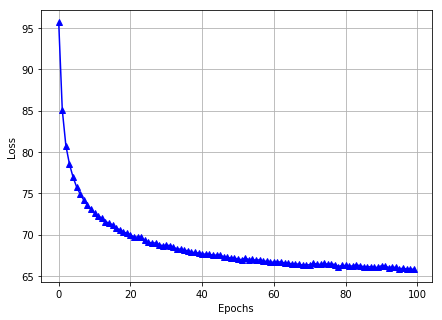

In [17]:
plt.figure(figsize=(7,5))
plt.plot(range(EPOCHS), train_loss, 'b-^')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.axis('tight')
plt.grid()

## D. Show some reconstructed images

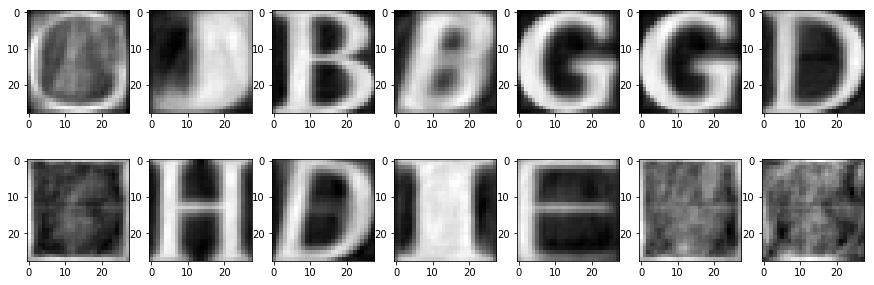

In [18]:
plt.figure(figsize=(15,5))
recon += 0.5
for i in np.arange(2*7):
    random_idx = np.random.randint(0,len(recon))
    plt.subplot(2,7,i+1)
    plt.imshow(np.reshape(recon[random_idx],(28,28)),cmap='gray')

## E. Plot Embeddings

In [19]:
#images, labels
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(outModelDir))
    embeddings = sess.run(embedded, feed_dict={x: images})
    
print('output embeddings.shape = {}'.format(embeddings.shape))

INFO:tensorflow:Restoring parameters from ./notMNIST-autoEncoder-shared-models-with-l2norm-on-embedding/mnist-fc-autoEncoder-model
output embeddings.shape = (200000, 2)


In [20]:
# dot colors
cmap=list()
for i in np.arange(n_classes):
    cmap.append(np.random.rand(1,3))
print(cmap[0])
permute_idx = np.random.permutation(n_classes)
cmap = [cmap[i] for i in permute_idx]

[[ 0.60317115  0.07784706  0.63940079]]


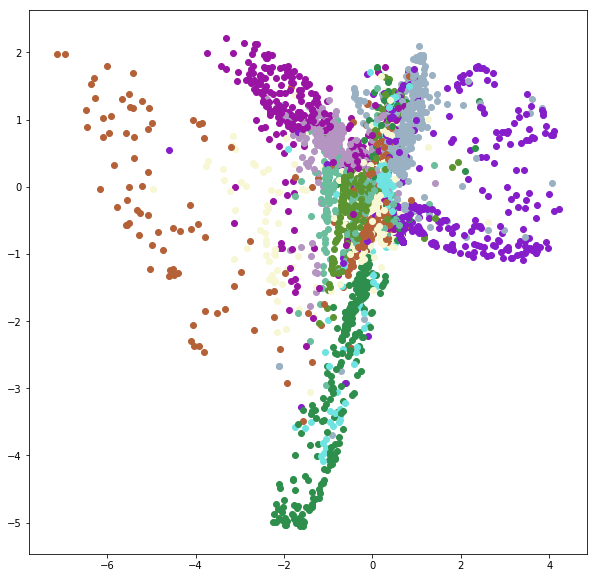

In [21]:
pylab.figure(figsize=(10,10))
for i in np.arange(0,img_num,50):
    x, y = (embeddings[i,0],embeddings[i,1])
    pylab.scatter(x,y,c=cmap[labels[i,0]])
    #pylab.scatter(x,y,c=[[1,1,1]])
    #pylab.annotate(str(labels[i][0]), xy=(x,y), xytext=(0, 0), textcoords='offset points',
                   #ha='right', va='bottom')
pylab.show()

## F. Do Image Generation by Decoder

In [24]:
codes = list()
for xdim in np.arange(-2,2,0.2):
    for ydim in np.arange(-2,2,0.2):
        codes.append([xdim,ydim])
print(len(codes))

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(outModelDir))
    sampled_img = sess.run(reconstruct,feed_dict={code:codes})

400
INFO:tensorflow:Restoring parameters from ./notMNIST-autoEncoder-shared-models-with-l2norm-on-embedding/mnist-fc-autoEncoder-model


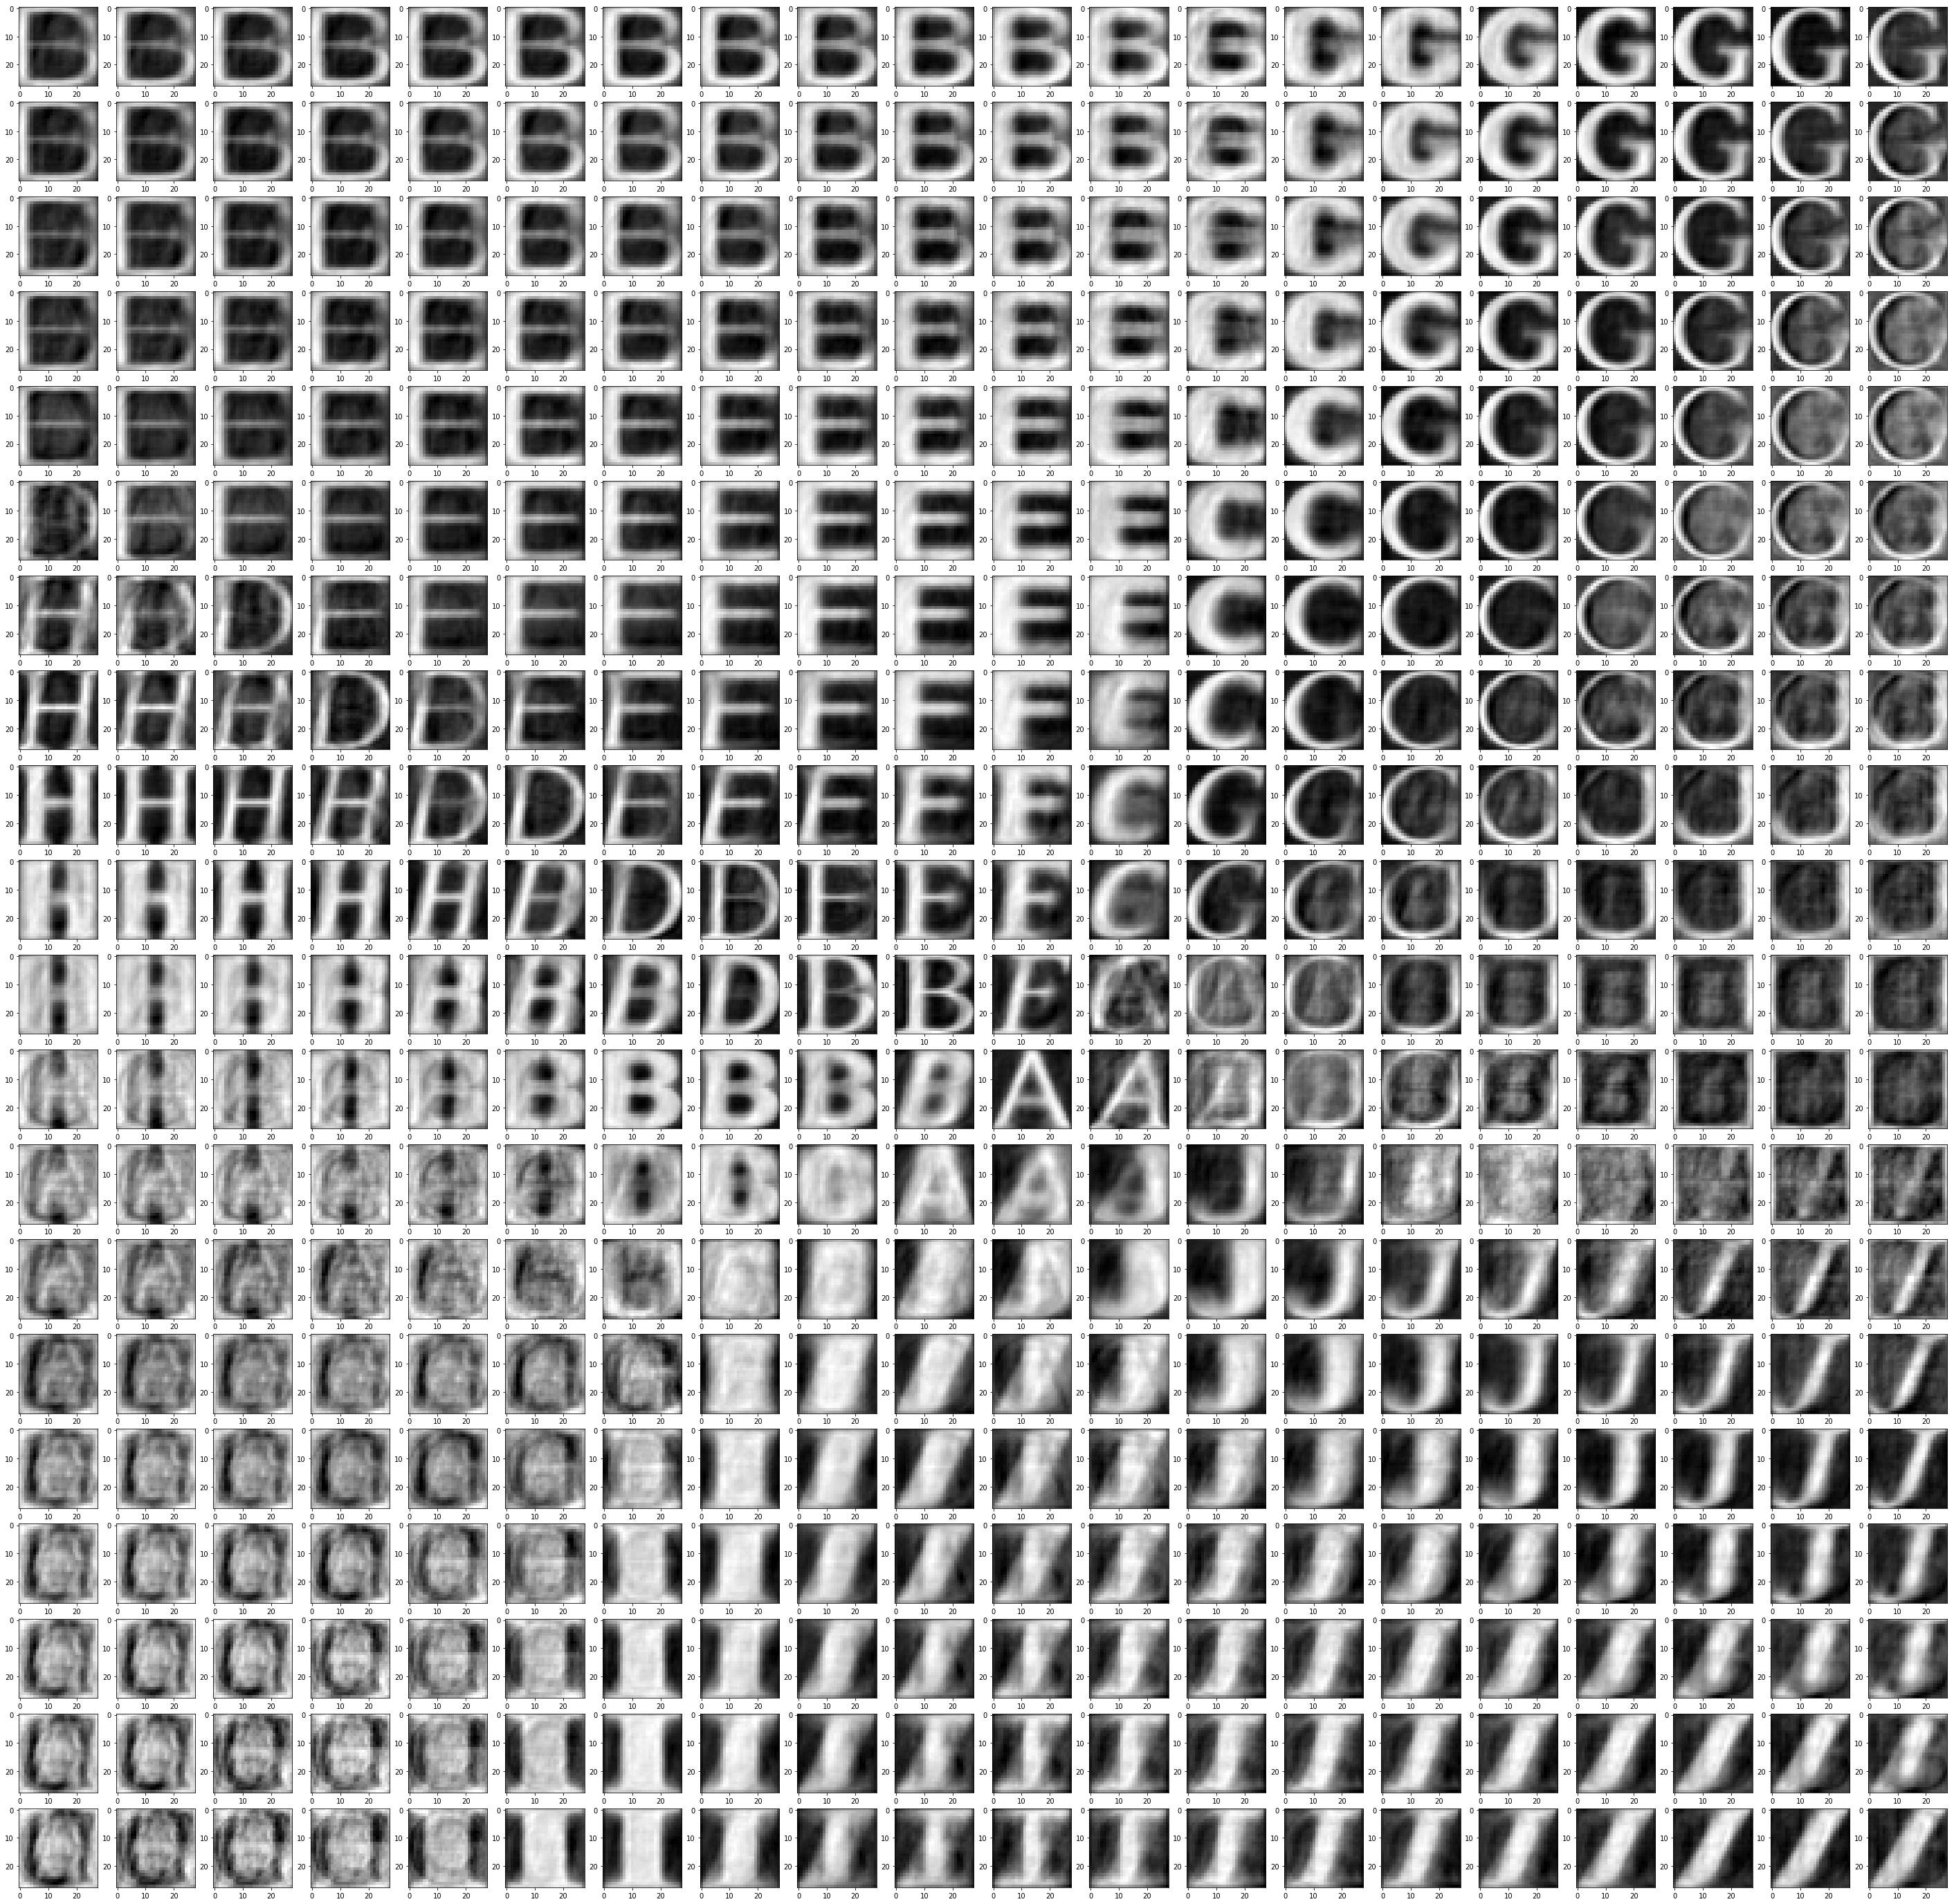

In [25]:
sampled_img.shape
plt.figure(figsize=(50,50))
sampled_img += 0.5
for i in np.arange(400):
    plt.subplot(20,20,i+1)
    plt.imshow(np.reshape(sampled_img[i],(28,28)),cmap='gray')